# Popular listings

## Import Data and Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reviews.csv will not be used in the analysis due to limited usability
calendar_csv = pd.read_csv('./project_1/calendar.csv')
listings_csv = pd.read_csv('./project_1/listings.csv')

## Project Motivation

The final question searches for reasons why some listings are more popular than others. We have calculated a **booked_ratio** from `calendar.csv` where listings which are booked for the date have no price value. We then explore the data and try to gather some insights why some listings have higher ratios than others.

## Data Cleaning and Preperation

Due to the unstructured format in which the .csv files are presented a lot of time and effort had to be invested in cleaning the data.

First we have checked for missing values in both datasets and dropped variables with more than 50% of the rows missing.

In [3]:
miss_calendar = calendar_csv.isnull().mean() * 100
miss_listings = pd.DataFrame(listings_csv.isnull().mean() * 100, columns=['missing'])

No columns were dropped from **calendar_csv** but four columns had to be dropped from **listings_csv** due to the amount of missing values.

In [4]:
# No columns to drop from 'calendar_csv'
miss_calendar

listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64

In [5]:
# Four columns had to be dropped from 'listings_csv' due to amount of missing values
miss_listings[miss_listings.missing>0].sort_values(by='missing', ascending=False)

,missing
license,100.000000
square_feet,97.459403
monthly_price,60.267156
security_deposit,51.126244
weekly_price,47.380828
notes,42.063908
neighborhood_overview,27.029859
cleaning_fee,26.977475
transit,24.463070
host_about,22.498690


We have then merged the two datasets using a _left_join_ on the **calendar_csv** to obtain a full timeseries of bookings and listing information.

In [6]:
# remove columns with more than half of the data missing and merge the two databases
listings_removed_cols = miss_listings[miss_listings.missing > 50]
listings_subset = listings_csv.loc[:, ~listings_csv.columns.isin(listings_removed_cols.index)]
listings_full = pd.merge(left=calendar_csv, right=listings_subset, how='left', left_on='listing_id',
                         right_on='id')

The next order of business was to clean the data by replacing values with more meaningful descriptors, parsing numercial variables and reducing the size of the data frame in order to speed up the calculations.

In [7]:
# remove URL columns which are redundant
url_cols = listings_full.filter(like='url')
listings_full = listings_full.loc[:, ~listings_full.columns.isin(url_cols.columns)]

# rename 'price' columns
listings_full.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)

# replace values with meaningful descriptors
cols_to_replace = {
    'host_is_superhost': {'t': 'superhost', 'f': 'regular'},
    'available': {'t': 'free', 'f': 'booked'}
}

for k, v in cols_to_replace.items():
    listings_full[k].replace(
        to_replace=v,
        inplace=True
    )

# add 'year' and 'month' variables
listings_full['year'] = pd.DatetimeIndex(listings_full['date']).year
listings_full['month'] = pd.DatetimeIndex(listings_full['date']).month

# drop cols with single unique value
cols_len_one = []

for i in listings_full.columns:
    if len(listings_full[i].unique()) == 1:
        cols_len_one.append(i)

listings_full = listings_full.loc[:, ~listings_full.columns.isin(cols_len_one)]

# reformat price columns into a float dtype
for col in ['price', 'weekly_price', 'cleaning_fee', 'extra_people']:
    listings_full[col] = listings_full[col].str.replace(',', '').str.replace('$', '').astype(float)

# reformat 'host_response_rate'
listings_full.host_response_rate = listings_full.host_response_rate.str.replace('%', '').astype(float) / 100

# further remove redundant columns
cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit',
                'host_name', 'host_location', 'host_about', 'street', 'neighborhood_overview', 'zipcode',
                'smart_location', 'latitude', 'longitude', 'price_y', 'calendar_updated', 'neighbourhood',
                'host_acceptance_rate', 'state', 'city', 'is_location_exact']

listings_full = listings_full.loc[:, ~listings_full.columns.isin(cols_to_drop)]

<ipython-input-7-6394f21e52b5>:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  listings_full[col] = listings_full[col].str.replace(',', '').str.replace('$', '').astype(float)


Lastly we calculate a ratio which show us what percentage of time the individual listing is booked for.

In [37]:
booked_listings = listings_full[listings_full['available'].isin(['booked'])]

bookings = listings_full.pivot_table(index='id', columns='available', values='listing_id', aggfunc=len)
bookings_db = pd.merge(left=listings_csv, right=bookings, how='left', on=['id'])
bookings_db.fillna(value={'booked': 0, 'free': 0}, inplace=True)
bookings_db['booked_ratio'] = bookings_db.booked / (bookings_db.booked + bookings_db.free)

## Data Analysis

### Plotting and Data Aggregations

This is the only part of the analysis for this part as no models have been applyed. Graphs and tables are the results of this analysis.

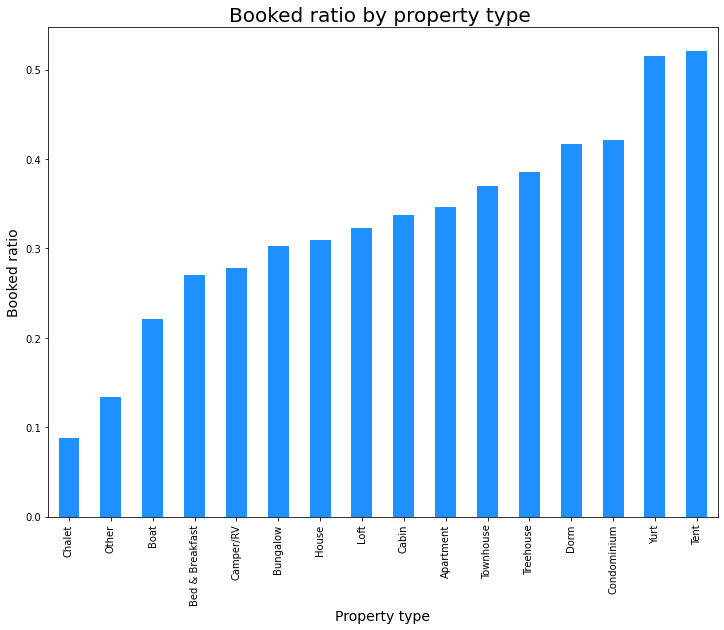

In [38]:
# property type
prop_type = bookings_db.property_type.unique()
colors=['dodgerblue' if i in ['House', 'Townhouse', 'Apartment', 'Condominium'] else 'orange' for i in prop_type]

f, ax = plt.subplots(1, 1, figsize = (12, 9))
bookings_db.pivot_table(index=['property_type'], values='booked_ratio', aggfunc=np.mean).sort_values(
    'booked_ratio').plot(kind='bar', ax=ax, legend=False, color=colors)
plt.title('Booked ratio by property type ', size=20)
plt.xlabel("Property type", size=14)
plt.ylabel("Booked ratio", size=14)
plt.show()

We can see from the graph a large discrepancy between the listing property types. If we consider only the property types with enough hosts to be relevant* we can see that the condominiums are the most popular, followed by townhouses, aparments and houses.

*relevant listings have been defined in the first question where we were looking for factors that define the listing price. Only listings with more than 50 unique hosts were condidered.

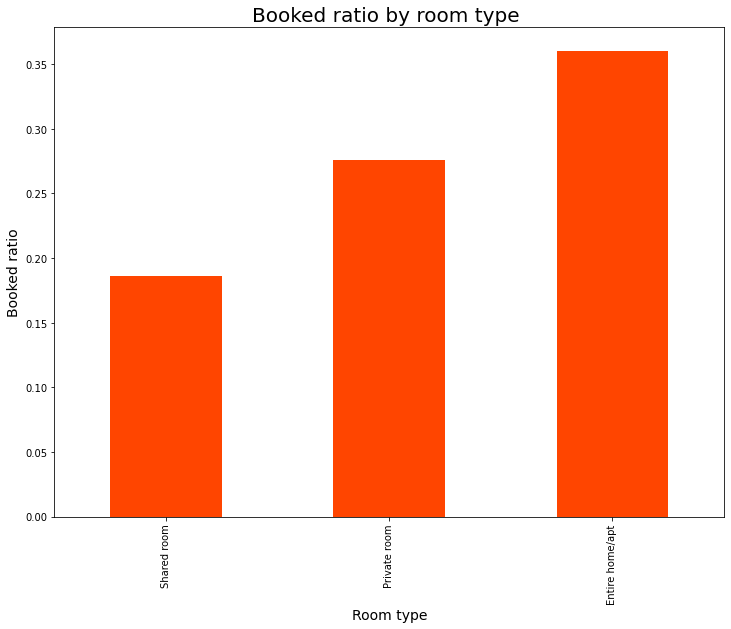

In [39]:
# room type
f, ax = plt.subplots(1, 1, figsize = (12, 9))
bookings_db.pivot_table(index=['room_type'], values='booked_ratio', aggfunc=np.mean).sort_values(
    'booked_ratio').plot(kind='bar', ax=ax, legend=False, color = ['orangered', 'darkorange', 'gold'])
plt.title('Booked ratio by room type ', size=20)
plt.xlabel("Room type", size=14)
plt.ylabel("Booked ratio", size=14)
plt.show()

Looking at the **room_type** variable we can see that entire homes and apartments are the most popular listings. They are almost twice as popular as shared rooms. Private rooms fall somewhere in between judging by the table below.

In [38]:
bookings_db.pivot_table(index=['room_type'], values='booked_ratio', aggfunc=np.mean).sort_values(
    'booked_ratio')

,booked_ratio
room_type,
Shared room,0.185997
Private room,0.275945
Entire home/apt,0.360391


Next thing on the list were city neighbourhoods. There are 87 neighbourhoods listed in Seattle dataset. Their popularity is bound to vary significantly.

In [69]:
print('Unique number of neighbourhoods in Seattle is ', len(bookings_db.neighbourhood_cleansed.unique()), '.', sep='')

Unique number of neighbourhoods in Seattle is 87.


The most popular neighbourhood appears to be **South Lake Union** which is located in the heart of the city and is filled with tourist attractions ([link](https://en.wikipedia.org/wiki/South_Lake_Union,_Seattle#Landmarks_and_historic_sites)). They are followed by **South Beacon Hill** and **North beach**, all popular tourist locations.

In [70]:
# neighbourhood
nbrhd=bookings_db.pivot_table(index=['neighbourhood_cleansed'], values=['booked_ratio'], aggfunc=[np.mean, len]).sort_values(
    ('mean', 'booked_ratio'), ascending=False)
nbrhd['%_of_listings'] = (nbrhd[('len', 'booked_ratio')]/sum(nbrhd[('len', 'booked_ratio')]))*100
nbrhd['average_booked_%'] = nbrhd[('mean', 'booked_ratio')]*100 

nbrhd.iloc[:, [3,2]][:10]

,average_booked_%,%_of_listings
,,
neighbourhood_cleansed,,
South Lake Union,54.672755,0.707177
South Beacon Hill,49.794521,0.104767
North Beach/Blue Ridge,48.610568,0.366684
Seaview,47.694064,0.314301
Riverview,45.582192,0.209534
Montlake,43.677001,0.497643
Madrona,43.485864,1.231011
Lower Queen Anne,43.252696,2.462022


In [75]:
bookings_db.pivot_table(index=['host_response_rate'], values='booked_ratio',
                        aggfunc=[np.mean])

,mean
,booked_ratio
host_response_rate,
100%,0.339188
17%,0.297260
25%,0.087671
30%,0.073973
31%,0.005479
33%,0.353425
38%,0.000000
40%,0.068721


<AxesSubplot:xlabel='accommodates'>

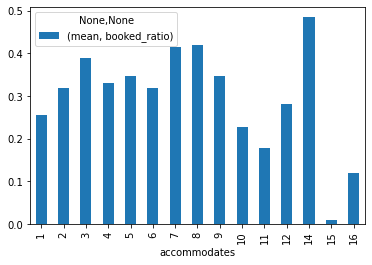

In [79]:
bookings_db.pivot_table(index='accommodates', values='booked_ratio', aggfunc=[np.mean]).plot(kind='bar')

We can see that the two variables approximately fit the conditions for the T-test. The results...